In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
warnings.filterwarnings('ignore')

## Notebook Overview

For this project, I applied data mining techniques to a dataset consisting of pre-draft metrics and statistics for NBA players to determine whether or not it was possible to create accurate models that could predict whether or not an NBA prospect would develop into a future All-Star.

This notebook contains the analysis performed to develop XGBoost models with this goal in mind.

For each model, hypothetical players numbered from 1-4 are supplied to test predictions into whether or not the model believes that they could develop into All-Stars or not. Players 1 and 2 represent Backcourt players (Point Guards and Shooting Guards), and Players 3 and 4 represent Frontcourt players (Small Forwards, Power Forwards, and Centers). These players are to be thought of as prospects that are up to be drafted into the NBA, and we as the user are to think of ourselves as GMs assessing them through our trained models.

## Loading the Data

In [3]:
data = 'C://Users//micha//Documents//DMII_Final_Project//draft_dataset.csv'

In [4]:
df_nba=pd.read_csv(data)

In [5]:
df_nba.head()

,Player,All_Star,Position,BC/FC,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,Dante Exum,0,PG,BC,77,78,82,103,35,138,32,135,196.0,1.32,1.05,23.5,2.7,1.5,2.0,8.8
1,Marcus Moore,0,SG,BC,76,77,81,102,30,132,25,127,202.0,1.32,1.05,24.6,3.3,2.5,0.3,6.4
2,DeAndre Liggins,0,SG,BC,77,78,83,104,31,135,27,131,202.0,1.33,1.06,24.0,5.8,3.0,2.1,13.6
3,Monte Morris,0,PG,BC,73,75,76,97,34,130,28,125,175.0,1.29,1.01,22.9,6.8,2.6,3.7,17.9
4,Kendall Marshall,0,PG,BC,75,76,78,96,37,133,31,127,198.0,1.26,1.03,24.6,7.2,2.3,8.0,28.0


In [6]:
df_nba.tail()

,Player,All_Star,Position,BC/FC,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
599,Elvin Hayes,1,PF,FC,80,81,84,106,34,140,30,136,235.0,1.31,1.04,25.8,31.0,17.2,1.4,50.9
600,Elgin Baylor,1,SF,FC,76,77,80,101,38,139,34,135,225.0,1.31,1.04,27.4,31.2,19.8,3.8,59.2
601,LeBron James,1,SF,FC,79,81,84,106,44,150,39,145,245.0,1.31,1.04,27.4,31.6,9.6,4.6,51.6
602,Spencer Haywood,1,PF,FC,79,80,85,106,36,142,32,138,230.0,1.33,1.06,25.9,32.2,22.1,3.4,61.5
603,Moses Malone,1,C,FC,81,82,86,110,35,145,30,140,215.0,1.34,1.05,23.0,36.0,26.0,1.5,64.6


In the context of this dataset, a "0" indicates that a player has never been named an All-Star, while a "1" indicates that a player has been named an All-Star.

In [7]:
df_nba.shape

(604, 20)

## Checking for nulls

In [8]:
df_nba.isnull().sum()

Player                    0
All_Star                  0
Position                  0
BC/FC                     0
Height_No_Shoes           0
Height_Shoes              0
Wingspan                  0
Standing_Reach            0
Vertical_Max              0
Vertical_Max_Reach        0
Vertical_No_Step          0
Vertical_No_Step_Reach    0
Weight                    0
Reach_Height_Ratio        0
Wingspan_Height_Ratio     0
BMI                       0
PTS                       0
REB                       0
AST                       0
TPV                       0
dtype: int64

As we can see, we have no nulls entries in any of our columns.

## Next, let's take a look at our dataset's balance with respect to our target classes

In [9]:
all_star_counts = df_nba['All_Star'].value_counts()

print(all_star_counts)

0    302
1    302
Name: All_Star, dtype: int64


As we can see, distribution of All-Stars to Non-All-Stars is equal.

## Now with respect to our target classes and position

In [10]:
positions = ['PG', 'SG', 'SF', 'PF', 'C']

for position in positions:
    players_by_position = df_nba[df_nba['Position'] == position]
    
    all_star_counts = players_by_position['All_Star'].value_counts()
    
    print(f"{position}s:")
    print("All Stars:", all_star_counts[1])
    print("Non-All Stars:", all_star_counts[0])
    print()

PGs:
All Stars: 54
Non-All Stars: 54

SGs:
All Stars: 65
Non-All Stars: 65

SFs:
All Stars: 57
Non-All Stars: 57

PFs:
All Stars: 74
Non-All Stars: 74

Cs:
All Stars: 52
Non-All Stars: 52



## Lastly, with respect to our target classes and whether or not a player's position is considered part of the Backcourt or Frontcourt.

In [11]:
bc_fcs = ['BC', 'FC']

for bc_fc in bc_fcs:
    players_by_bc_fc = df_nba[df_nba['BC/FC'] == bc_fc]
    
    all_star_counts = players_by_bc_fc['All_Star'].value_counts()
    
    print(f"{bc_fc}s:")
    print("All Stars:", all_star_counts[1])
    print("Non-All Stars:", all_star_counts[0])
    print()

BCs:
All Stars: 119
Non-All Stars: 119

FCs:
All Stars: 183
Non-All Stars: 183



## - Balance Check Complete -

## Separating Backcourt and Frontcourt into Two New Dataframes

Next, in order for the dataset to be mined for proper insights, it is important to create two separate dataframes that reflect data for Backcourt and Frontcourt players. The reason for this is that qualities that make a great Backcourt player (Point Guard or Shooting Guard) tend not to be the qualities that makes a great Frontcourt player (Small Forward, Power Forward, and Center).

Before doing that, however, we will first drop the player column from the existing dataframe as they are not features that are not needed for any subsequent analysis that occurs past this point.

In [12]:
df_nba.drop('Player', axis=1, inplace=True)
df_nba

,All_Star,Position,BC/FC,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,0,PG,BC,77,78,82,103,35,138,32,135,196.0,1.32,1.05,23.5,2.7,1.5,2.0,8.8
1,0,SG,BC,76,77,81,102,30,132,25,127,202.0,1.32,1.05,24.6,3.3,2.5,0.3,6.4
2,0,SG,BC,77,78,83,104,31,135,27,131,202.0,1.33,1.06,24.0,5.8,3.0,2.1,13.6
3,0,PG,BC,73,75,76,97,34,130,28,125,175.0,1.29,1.01,22.9,6.8,2.6,3.7,17.9
4,0,PG,BC,75,76,78,96,37,133,31,127,198.0,1.26,1.03,24.6,7.2,2.3,8.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1,PF,FC,80,81,84,106,34,140,30,136,235.0,1.31,1.04,25.8,31.0,17.2,1.4,50.9
600,1,SF,FC,76,77,80,101,38,139,34,135,225.0,1.31,1.04,27.4,31.2,19.8,3.8,59.2
601,1,SF,FC,79,81,84,106,44,150,39,145,245.0,1.31,1.04,27.4,31.6,9.6,4.6,51.6
602,1,PF,FC,79,80,85,106,36,142,32,138,230.0,1.33,1.06,25.9,32.2,22.1,3.4,61.5


In [13]:
df_bc = df_nba[df_nba['BC/FC'] == 'BC']
df_fc = df_nba[df_nba['BC/FC'] == 'FC']

In [14]:
df_bc

,All_Star,Position,BC/FC,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,0,PG,BC,77,78,82,103,35,138,32,135,196.0,1.32,1.05,23.5,2.7,1.5,2.0,8.8
1,0,SG,BC,76,77,81,102,30,132,25,127,202.0,1.32,1.05,24.6,3.3,2.5,0.3,6.4
2,0,SG,BC,77,78,83,104,31,135,27,131,202.0,1.33,1.06,24.0,5.8,3.0,2.1,13.6
3,0,PG,BC,73,75,76,97,34,130,28,125,175.0,1.29,1.01,22.9,6.8,2.6,3.7,17.9
4,0,PG,BC,75,76,78,96,37,133,31,127,198.0,1.26,1.03,24.6,7.2,2.3,8.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1,SG,BC,77,78,81,102,32,134,26,128,180.0,1.31,1.04,21.3,29.1,5.5,2.9,41.1
234,1,SG,BC,77,78,83,107,38,145,33,140,200.0,1.37,1.06,24.0,30.8,12.0,6.5,57.5
235,1,PG,BC,76,77,80,101,38,139,32,133,205.0,1.31,1.04,25.0,33.8,15.2,7.1,65.0
236,1,SG,BC,75,76,79,100,34,134,28,128,190.0,1.32,1.04,23.7,34.6,7.3,3.3,49.3


In [15]:
df_bc = df_bc.drop(columns=['BC/FC'])
df_bc

,All_Star,Position,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,0,PG,77,78,82,103,35,138,32,135,196.0,1.32,1.05,23.5,2.7,1.5,2.0,8.8
1,0,SG,76,77,81,102,30,132,25,127,202.0,1.32,1.05,24.6,3.3,2.5,0.3,6.4
2,0,SG,77,78,83,104,31,135,27,131,202.0,1.33,1.06,24.0,5.8,3.0,2.1,13.6
3,0,PG,73,75,76,97,34,130,28,125,175.0,1.29,1.01,22.9,6.8,2.6,3.7,17.9
4,0,PG,75,76,78,96,37,133,31,127,198.0,1.26,1.03,24.6,7.2,2.3,8.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1,SG,77,78,81,102,32,134,26,128,180.0,1.31,1.04,21.3,29.1,5.5,2.9,41.1
234,1,SG,77,78,83,107,38,145,33,140,200.0,1.37,1.06,24.0,30.8,12.0,6.5,57.5
235,1,PG,76,77,80,101,38,139,32,133,205.0,1.31,1.04,25.0,33.8,15.2,7.1,65.0
236,1,SG,75,76,79,100,34,134,28,128,190.0,1.32,1.04,23.7,34.6,7.3,3.3,49.3


In [16]:
df_bc = df_bc.drop(columns=['Position'])
df_bc

,All_Star,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,0,77,78,82,103,35,138,32,135,196.0,1.32,1.05,23.5,2.7,1.5,2.0,8.8
1,0,76,77,81,102,30,132,25,127,202.0,1.32,1.05,24.6,3.3,2.5,0.3,6.4
2,0,77,78,83,104,31,135,27,131,202.0,1.33,1.06,24.0,5.8,3.0,2.1,13.6
3,0,73,75,76,97,34,130,28,125,175.0,1.29,1.01,22.9,6.8,2.6,3.7,17.9
4,0,75,76,78,96,37,133,31,127,198.0,1.26,1.03,24.6,7.2,2.3,8.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,1,77,78,81,102,32,134,26,128,180.0,1.31,1.04,21.3,29.1,5.5,2.9,41.1
234,1,77,78,83,107,38,145,33,140,200.0,1.37,1.06,24.0,30.8,12.0,6.5,57.5
235,1,76,77,80,101,38,139,32,133,205.0,1.31,1.04,25.0,33.8,15.2,7.1,65.0
236,1,75,76,79,100,34,134,28,128,190.0,1.32,1.04,23.7,34.6,7.3,3.3,49.3


In [17]:
df_fc = df_fc.drop(columns=['BC/FC'])
df_fc

,All_Star,Position,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
238,0,C,84,85,86,113,29,142,21,134,255.0,1.33,1.01,25.4,1.3,1.7,0.1,3.2
239,0,C,85,86,89,112,30,142,29,141,289.0,1.30,1.03,28.1,1.5,1.4,0.1,3.1
240,0,C,80,81,86,109,25,134,23,132,263.0,1.35,1.06,28.9,1.5,1.5,2.5,8.8
241,0,SF,77,78,81,104,36,140,30,134,208.0,1.33,1.04,24.8,1.6,1.3,0.2,3.3
242,0,C,86,87,90,112,27,139,24,136,266.0,1.29,1.03,25.3,1.8,0.7,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1,PF,80,81,84,106,34,140,30,136,235.0,1.31,1.04,25.8,31.0,17.2,1.4,50.9
600,1,SF,76,77,80,101,38,139,34,135,225.0,1.31,1.04,27.4,31.2,19.8,3.8,59.2
601,1,SF,79,81,84,106,44,150,39,145,245.0,1.31,1.04,27.4,31.6,9.6,4.6,51.6
602,1,PF,79,80,85,106,36,142,32,138,230.0,1.33,1.06,25.9,32.2,22.1,3.4,61.5


In [18]:
df_fc = df_fc.drop(columns=['Position'])
df_fc

,All_Star,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
238,0,84,85,86,113,29,142,21,134,255.0,1.33,1.01,25.4,1.3,1.7,0.1,3.2
239,0,85,86,89,112,30,142,29,141,289.0,1.30,1.03,28.1,1.5,1.4,0.1,3.1
240,0,80,81,86,109,25,134,23,132,263.0,1.35,1.06,28.9,1.5,1.5,2.5,8.8
241,0,77,78,81,104,36,140,30,134,208.0,1.33,1.04,24.8,1.6,1.3,0.2,3.3
242,0,86,87,90,112,27,139,24,136,266.0,1.29,1.03,25.3,1.8,0.7,0.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,1,80,81,84,106,34,140,30,136,235.0,1.31,1.04,25.8,31.0,17.2,1.4,50.9
600,1,76,77,80,101,38,139,34,135,225.0,1.31,1.04,27.4,31.2,19.8,3.8,59.2
601,1,79,81,84,106,44,150,39,145,245.0,1.31,1.04,27.4,31.6,9.6,4.6,51.6
602,1,79,80,85,106,36,142,32,138,230.0,1.33,1.06,25.9,32.2,22.1,3.4,61.5


## - Dataframe Separation Complete -

## Model for Backcourt Players

## XGBoost (BC)

In [30]:
y_target = df_bc['All_Star']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df_bc.drop(['All_Star'], axis = 'columns'), y_target, test_size = 0.2)

In [32]:
# I ran a grid search already here to find the best parameters and chose not to repeat it as it is time consuming

#xgb_model1 = xgb.XGBClassifier(objective='binary:hinge', seed=42)

#param_grid = {
    #'gamma': [0.1, 0.3, 0.5],
    #'learning_rate': [0.01, 0.05, 0.1],
    #'max_depth': [3, 5, 7],
    #'reg_lambda': [1, 10, 100],
    #'scale_pos_weight': [1, 2, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.5, 0.7, 0.9]
#}

#grid_search = GridSearchCV(estimator=xgb_model1, param_grid=param_grid, cv=3, scoring='roc_auc')

#grid_search.fit(X_train, y_train)

#print("Best parameters found:", grid_search.best_params_)

#best_model = grid_search.best_estimator_

#test_auc = best_model.score(X_test, y_test)
#print("Test AUC:", test_auc)

#Best parameters found: {'colsample_bytree': 0.7, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 0.9}
#Test AUC: 0.8333333333333334

In [33]:
xgb_model1 = xgb.XGBClassifier(objective='binary:hinge', seed=42,gamma=0.5,learn_rate=0.1,max_depth=3,
                            reg_lambda=1,scale_pos_weight=1,subsample=.9, colsample_by_tree=0.7)
xgb_model1.fit(X_train,y_train,verbose=True,early_stopping_rounds=5,eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.56250
[1]	validation_0-aucpr:0.71898
[2]	validation_0-aucpr:0.74945
[3]	validation_0-aucpr:0.78475
[4]	validation_0-aucpr:0.77318
[5]	validation_0-aucpr:0.81041
[6]	validation_0-aucpr:0.84430
[7]	validation_0-aucpr:0.83238
[8]	validation_0-aucpr:0.86471
[9]	validation_0-aucpr:0.83238
[10]	validation_0-aucpr:0.86471
[11]	validation_0-aucpr:0.86471
[12]	validation_0-aucpr:0.89988
[13]	validation_0-aucpr:0.83238
[14]	validation_0-aucpr:0.91125
[15]	validation_0-aucpr:0.88784
[16]	validation_0-aucpr:0.93318
[17]	validation_0-aucpr:0.89900
[18]	validation_0-aucpr:0.88822
[19]	validation_0-aucpr:0.88784
[20]	validation_0-aucpr:0.86471
[21]	validation_0-aucpr:0.89900


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.7, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learn_rate=0.1, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [34]:
y_pred = xgb_model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score for XGBoost (BC):", round(accuracy * 100, 2), "%")
print("Precision Score for XGBoost (BC):", round(precision * 100, 2), "%")
print("Recall Score for XGBoost (BC):", round(recall * 100, 2), "%")
print("F1-Score for XGBoost (BC):", round(f1 * 100, 2), "%")

Accuracy Score for XGBoost (BC): 91.67 %
Precision Score for XGBoost (BC): 96.0 %
Recall Score for XGBoost (BC): 88.89 %
F1-Score for XGBoost (BC): 92.31 %


In [35]:
cmxgb1 = cm(y_test, y_pred)
cmxgb1

array([[20,  1],
       [ 3, 24]], dtype=int64)

Text(0.5, 1.0, 'XGBoost Confusion Matrix (BC)')

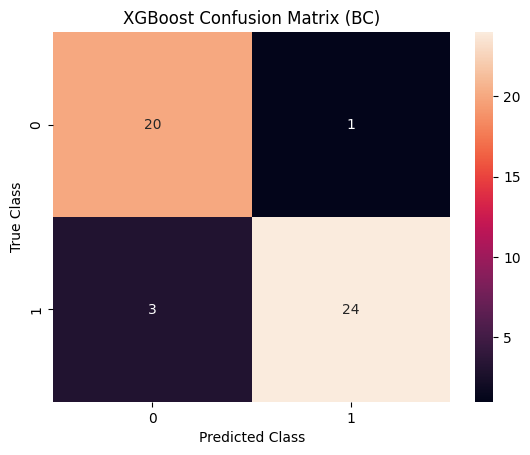

In [36]:
ax = plt.subplot()
sns.heatmap(cmxgb1, annot=True, fmt = 'g', ax=ax)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('XGBoost Confusion Matrix (BC)')

In [37]:
print(20/(20+1),24/(24+3))

0.9523809523809523 0.8888888888888888


Result: The XGBoost model gets 95.24% of the non-All-Stars correct and 88.89% of the All-Stars correct when predicting for Backcourt players.

## Player Predictions (BC)

### Player 1
A 6'1, 189-pound player with a 33-inch max vertical jump who averaged 8 points, 2 rebounds, and 3 assists per game.

In [38]:
player1 = {
    'Height_No_Shoes': 72,
    'Height_Shoes': 73,
    'Wingspan': 75,  
    'Standing_Reach': 97,
    'Vertical_Max': 33,
    'Vertical_Max_Reach': 130,
    'Vertical_No_Step': 27,
    'Vertical_No_Step_Reach': 124,
    'Weight': 189,
    'Reach_Height_Ratio': 1.33,
    'Wingspan_Height_Ratio': 1.03,
    'BMI': 24.9,
    'PTS': 8,
    'REB': 2,
    'AST': 3,
    'TPV': 16.9
}

player1_df = pd.DataFrame([player1])
player1_df

,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,72,73,75,97,33,130,27,124,189,1.33,1.03,24.9,8,2,3,16.9


In [39]:
prediction_player1 = xgb_model1.predict(player1_df)

print('1 = All-Star')
print('0 = Not an All-Star')
print(f'For this player, the model predicts: {prediction_player1[0]}')

1 = All-Star
0 = Not an All-Star
For this player, the model predicts: 0


### Player 2
A 6'5, 205-pound player with a 38-inch max vertical jump who averaged 22 points, 4 rebounds, and 8 assists per game.

In [40]:
player2 = {
    'Height_No_Shoes': 76,
    'Height_Shoes': 77,
    'Wingspan': 83,  
    'Standing_Reach': 102,
    'Vertical_Max': 38,
    'Vertical_Max_Reach': 140,
    'Vertical_No_Step': 32,
    'Vertical_No_Step_Reach': 134,
    'Weight': 205,
    'Reach_Height_Ratio': 1.4,
    'Wingspan_Height_Ratio': 1.08,
    'BMI': 24.3,
    'PTS': 22,
    'REB': 4,
    'AST': 8,
    'TPV': 44.4
}

player2_df = pd.DataFrame([player2])
player2_df

,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,76,77,83,102,38,140,32,134,205,1.4,1.08,24.3,22,4,8,44.4


In [41]:
prediction_player2 = xgb_model1.predict(player2_df)

print('1 = All-Star')
print('0 = Not an All-Star')
print(f'For this player, the model predicts: {prediction_player2[0]}')

1 = All-Star
0 = Not an All-Star
For this player, the model predicts: 1


## Model for Frontcourt Players

## XGBoost (FC)

In [85]:
y_target = df_fc['All_Star']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df_fc.drop(['All_Star'], axis = 'columns'), y_target, test_size = 0.2)

In [87]:
xgb_model2 = xgb.XGBClassifier(objective='binary:hinge', seed=42,gamma=0.5,learn_rate=0.1,max_depth=3,
                            reg_lambda=1,scale_pos_weight=1,subsample=.9, colsample_by_tree=0.7)
xgb_model2.fit(X_train,y_train,verbose=True,early_stopping_rounds=5,eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.51351
[1]	validation_0-aucpr:0.76696
[2]	validation_0-aucpr:0.75832
[3]	validation_0-aucpr:0.75832
[4]	validation_0-aucpr:0.79122
[5]	validation_0-aucpr:0.82716
[6]	validation_0-aucpr:0.82716
[7]	validation_0-aucpr:0.82716
[8]	validation_0-aucpr:0.84897
[9]	validation_0-aucpr:0.84897
[10]	validation_0-aucpr:0.82870
[11]	validation_0-aucpr:0.84897
[12]	validation_0-aucpr:0.87909
[13]	validation_0-aucpr:0.82870
[14]	validation_0-aucpr:0.81966
[15]	validation_0-aucpr:0.82870
[16]	validation_0-aucpr:0.81966
[17]	validation_0-aucpr:0.83082


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_by_tree=0.7, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learn_rate=0.1, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [88]:
y_pred = xgb_model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy Score for XGBoost (FC):", round(accuracy * 100, 2), "%")
print("Precision Score for XGBoost (FC):", round(precision * 100, 2), "%")
print("Recall Score for XGBoost (FC):", round(recall * 100, 2), "%")
print("F1-Score for XGBoost (FC):", round(f1 * 100, 2), "%")

Accuracy Score for XGBoost (FC): 90.54 %
Precision Score for XGBoost (FC): 89.74 %
Recall Score for XGBoost (FC): 92.11 %
F1-Score for XGBoost (FC): 90.91 %


In [89]:
cmxgb2 = cm(y_test, y_pred)
cmxgb2

array([[32,  4],
       [ 3, 35]], dtype=int64)

Text(0.5, 1.0, 'XGBoost Confusion Matrix (FC)')

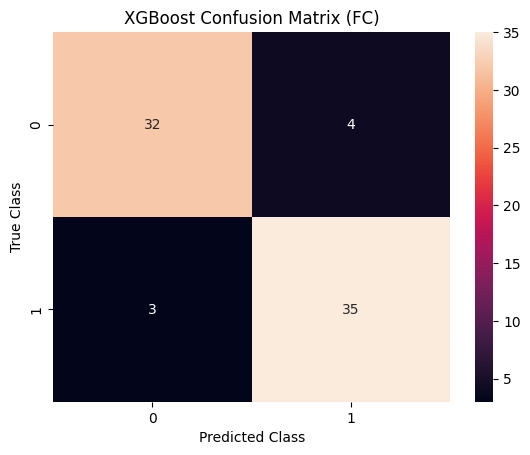

In [90]:
ax = plt.subplot()
sns.heatmap(cmxgb2, annot=True, fmt = 'g', ax=ax)
ax.set_xlabel('Predicted Class')
ax.set_ylabel('True Class')
ax.set_title('XGBoost Confusion Matrix (FC)')

In [91]:
print(32/(32+4),35/(35+3))

0.8888888888888888 0.9210526315789473


Result: The XGBoost model gets 88.89% of the non-All-Stars correct and 92.11% of the All-Stars correct when predicting for Frontcourt players.

## Player Predictions (FC)

### Player 3
A 6'5, 220-pound player with a 33-inch max vertical jump who averaged 12 points, 8 rebounds, and 2 assists per game.

In [92]:
player3 = {
    'Height_No_Shoes': 76,
    'Height_Shoes': 77,
    'Wingspan': 80,  
    'Standing_Reach': 105,
    'Vertical_Max': 33,
    'Vertical_Max_Reach': 141,
    'Vertical_No_Step': 28,
    'Vertical_No_Step_Reach': 136,
    'Weight': 220,
    'Reach_Height_Ratio': 1.4,
    'Wingspan_Height_Ratio': 1.08,
    'BMI': 26.1,
    'PTS': 12,
    'REB': 8,
    'AST': 2,
    'TPV': 24.4
}

player3_df = pd.DataFrame([player3])
player3_df

,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,76,77,80,105,33,141,28,136,220,1.4,1.08,26.1,12,8,2,24.4


In [93]:
prediction_player3 = xgb_model2.predict(player3_df)

print('1 = All-Star')
print('0 = Not an All-Star')
print(f'For this player, the model predicts: {prediction_player3[0]}')

1 = All-Star
0 = Not an All-Star
For this player, the model predicts: 0


### Player 4
A 6'10, 210-pound player with a 37-inch max vertical jump who averaged 18 points, 7 rebounds, and 4 assists per game.

In [94]:
player4 = {
    'Height_No_Shoes': 81,
    'Height_Shoes': 82,
    'Wingspan': 86,  
    'Standing_Reach': 110,
    'Vertical_Max': 37,
    'Vertical_Max_Reach': 147,
    'Vertical_No_Step': 33,
    'Vertical_No_Step_Reach': 143,
    'Weight': 210,
    'Reach_Height_Ratio': 1.34,
    'Wingspan_Height_Ratio': 1.05,
    'BMI': 22,
    'PTS': 18,
    'REB': 7,
    'AST': 4,
    'TPV': 34
}

player4_df = pd.DataFrame([player4])
player4_df

,Height_No_Shoes,Height_Shoes,Wingspan,Standing_Reach,Vertical_Max,Vertical_Max_Reach,Vertical_No_Step,Vertical_No_Step_Reach,Weight,Reach_Height_Ratio,Wingspan_Height_Ratio,BMI,PTS,REB,AST,TPV
0,81,82,86,110,37,147,33,143,210,1.34,1.05,22,18,7,4,34


In [95]:
prediction_player4 = xgb_model2.predict(player4_df)

print('1 = All-Star')
print('0 = Not an All-Star')
print(f'For this player, the model predicts: {prediction_player4[0]}')

1 = All-Star
0 = Not an All-Star
For this player, the model predicts: 1


## Conclusions

For both Backcourt and Frontcourt players, the XGBoost model performed well. The XGBoost model achieved an overall accuracy score of 91.67% for Backcourt players and 90.54% for Frontcourt players.

XGBoost also ended up making the same predictions for the sample players 1-4 as Random Forest did.